In [ ]:
import requests
import wikitextparser as wtp
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk import download
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import bigrams
from collections import Counter
import matplotlib.pyplot as plt

In [9]:
def get_turing_award_recipients():
    #Wikidata API endpoint
    wikidata_sparql_url = "https://query.wikidata.org/sparql"
    
    #Query to retrieve Turing Award recipients
    query = """
    SELECT ?recipient ?recipientLabel WHERE {
      ?recipient wdt:P166 wd:Q185667.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }
    """

    #Set up headers for the SPARQL request
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    #Request format
    response = requests.get(url=wikidata_sparql_url, headers=headers, params={"query": query, "format": "json"})
    
    #Storing the JSON response
    data = response.json()

    #Extracting the recipients and their names from JSON
    recipients = [(entry['recipient']['value'].split('/')[-1], entry['recipientLabel']['value']) for entry in data['results']['bindings']]
    
    return recipients

In [10]:
def get_wikipedia_content_by_id(wikidata_id):
    #Wikidata API endpoint
    wikidata_api_url = "https://www.wikidata.org/w/api.php"

    #Wikipedia API endpoint
    wikipedia_api_url = "https://en.wikipedia.org/w/api.php"

    #Parameters for the Wikidata API request to get Wikipedia page title
    wikidata_params = {
        "action": "wbgetentities",
        "ids": wikidata_id,
        "props": "sitelinks",
        "format": "json"
    }

    try:
        #Request for Wikidata API
        wikidata_response = requests.get(url=wikidata_api_url, params=wikidata_params)
        wikidata_data = wikidata_response.json()

        #Extracting Wikipedia page title in english
        if "sitelinks" in wikidata_data.get("entities", {}).get(wikidata_id, {}):
            wikipedia_title = wikidata_data["entities"][wikidata_id]["sitelinks"]["enwiki"]["title"]

            #Parameters for the Wikipedia API
            wikipedia_params = {
                "action": "query",
                "format": "json",
                "prop": "revisions",
                "rvprop": "content",
                "rvslots": "main",
                "titles": wikipedia_title,
            }

            #Request for Wikipedia API
            wikipedia_response = requests.get(url=wikipedia_api_url, params=wikipedia_params)
            wikipedia_data = wikipedia_response.json()

            #Extracting the page content
            pages = wikipedia_data.get("query", {}).get("pages", {})
            if pages:
                page_id = next(iter(pages))  # Get the first (and only) page ID
                revisions = pages[page_id].get("revisions", [])

                #Check if there are revisions and extract content
                if revisions:
                    return f"Wikidata ID: {wikidata_id}\nWikipedia Content:\n{revisions[0].get('slots', {}).get('main', {}).get('*')}\n{'='*50}\n"

        #Edge case: If no data found
        return f"No data found for Wikidata ID: {wikidata_id}"

    except KeyError as e:
        return f"Error retrieving data for Wikidata ID: {wikidata_id}. KeyError: {e}"

In [5]:
turing_award_recipients = get_turing_award_recipients()
award_winners = {}

# Iterate through the list of tuples (wikidata_id, name)
for wikidata_id, name in turing_award_recipients:
    # Get Wikipedia content for the current winner
    content = get_wikipedia_content_by_id(wikidata_id)

    # Parse wikitext using wikitextparser
    parsed = wtp.parse(content)

    # Extract relevant information from the parsed wikitext
    intro = None
    gender = None
    birth_date = None
    birth_place = None
    employer = []
    educated_at = []

    # Extract introduction from the first paragraph
    intro_section = parsed.sections[0] if parsed.sections else None
    intro = intro_section.string.strip() if intro_section and intro_section.string else None

    # Iterate through sections to find additional information
    for section in parsed.sections:
        if section.string:
            for item in section.string.split("|"):
                key_value = item.split("=")
                if len(key_value) == 2:
                    key = key_value[0].strip().lower()
                    value = key_value[1].strip()

                    if key == 'birth_date':
                        birth_date = value
                    elif key == 'birth_place':
                        birth_place = value
                    elif 'gender' in key:
                        gender = value
                    elif 'employer' in key:
                        employer.append(value)
                    elif 'education' in key:
                        educated_at.append(value)

    # Fill the award_winners dictionary with the extracted information
    award_winners[name] = {
        'intro': intro,
        'gender': gender,
        'birth_date': birth_date,
        'birth_place': birth_place,
        'employer': employer if employer else None,
        'educated_at': educated_at if educated_at else None
    }

In [11]:
#Print the name of all award winners in alphabetical order
sorted_award_winners = []
for name in sorted(award_winners.keys()):
    sorted_award_winners.append(name)
print(sorted_award_winners)

['Adi Shamir', 'Alan Kay', 'Alan Perlis', 'Alfred Aho', 'Allen Newell', 'Amir Pnueli', 'Andrew Yao', 'Barbara Liskov', 'Bob Kahn', 'Butler Lampson', 'Charles Bachman', 'Charles P. Thacker', 'Dana Scott', 'David A. Patterson', 'Dennis M. Ritchie', 'Donald Knuth', 'Douglas Engelbart', 'E. Allen Emerson', 'Edgar F. Codd', 'Edmund M. Clarke', 'Edsger W. Dijkstra', 'Edward Feigenbaum', 'Edwin Catmull', 'Fernando J. Corbató', 'Frances E. Allen', 'Fred Brooks', 'Geoffrey Hinton', 'Herbert Simon', 'Iosif Sifakis', 'Ivan Sutherland', 'Jack Dongarra', 'James H. Wilkinson', 'Jeffrey David Ullman', 'Jim Gray', 'John Backus', 'John Cocke', 'John Edward Hopcroft', 'John L. Hennessy', 'John McCarthy', 'Judea Pearl', 'Juris Hartmanis', 'Ken Thompson', 'Kenneth E. Iverson', 'Kristen Nygaard', 'Leonard Adleman', 'Leslie Lamport', 'Leslie Valiant', 'Manuel Blum', 'Martin Edward Hellman', 'Marvin Minsky', 'Maurice Wilkes', 'Michael O. Rabin', 'Michael Stonebraker', 'Niklaus Wirth', 'Ole-Johan Dahl', 'Pat 

In [ ]:
#Initialize the award_winners_intro DataFrame columns
columns = ['winner_name', 'count_words', 'count_sentences', 'count_paragraphs', 'common_words', 'common_words_after_preprocessing']
award_winners_intro = pd.DataFrame(columns=columns)

for winner_name, info in award_winners.items():
    intro_text = info['intro']

    #Remove punctuation and stopwords from intro
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(intro_text)
    words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]

    #Count words, sentences, and paragraphs for intro
    count_words = len(words)
    count_sentences = len(sent_tokenize(intro_text))
    count_paragraphs = len(intro_text.split('\n\n'))

    #Calculate common words and common words after preprocessing
    common_words = [word.lower() for word, freq in FreqDist(words).most_common(10)]
    common_words_after_preprocessing = [word for word, freq in FreqDist(words).most_common(10)]

    #Adding data to award_winners_intro
    data = [winner_name, count_words, count_sentences, count_paragraphs, common_words, common_words_after_preprocessing]
    award_winners_intro = award_winners_intro.append(pd.Series(data, index=columns), ignore_index=True)

In [13]:
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing


In [59]:
porter_stemmer = PorterStemmer()

#List to store preprocessed intro words
intro_words = []

#Remove stopwords and punctuation
for winner_name, info in award_winners.items():
    intro_text = info['intro']
    stop_words = set(stopwords.words("english"))
    words = [word.lower() for word in intro_text.split() if word.isalnum() and word.lower() not in stop_words]
    intro_words+=words

#Print the number of unique words before stemming
unique_words_before_stemming = set(intro_words)
print(f"Number of unique words before stemming: {len(unique_words_before_stemming)}")

#Apply the PorterStemmer
intro_words_stemmed = [porter_stemmer.stem(word) for word in intro_words]

#Print the number of unique words after stemming
unique_words_after_stemming = set(intro_words_stemmed)
print(f"Number of unique words after stemming: {len(unique_words_after_stemming)}")

Number of unique words before stemming: 2299
Number of unique words after stemming: 1981


In [60]:
snowball_stemmer = SnowballStemmer("english")

#List to store preprocessed intro words
intro_words = []

for winner_name, info in award_winners.items():
    intro_text = info['intro']
    stop_words = set(stopwords.words("english"))
    words = [word.lower() for word in intro_text.split() if word.isalnum() and word.lower() not in stop_words]
    intro_words+= words

#Print the number of unique words before stemming
unique_words_before_stemming = set(intro_words)
print(f"Number of unique words before stemming: {len(unique_words_before_stemming)}")

#Apply SnowballStemmer
intro_words_stemmed_snowball = [snowball_stemmer.stem(word) for word in intro_words]

#Print the number of unique words after stemming
unique_words_after_stemming_snowball = set(intro_words_stemmed_snowball)
print(f"Number of unique words after stemming (SnowballStemmer): {len(unique_words_after_stemming_snowball)}")

Number of unique words before stemming: 2299
Number of unique words after stemming (SnowballStemmer): 1974


In [61]:
lemmatizer = WordNetLemmatizer()

#List to store preprocessed intro words
intro_words = []

#Remove stopwords and punctuation
for winner_name, info in award_winners.items():
    intro_text = info['intro']
    stop_words = set(stopwords.words("english"))
    words = [word.lower() for word in intro_text.split() if word.isalnum() and word.lower() not in stop_words]
    intro_words += words  # Use 'append' if you prefer

#Print the number of unique words before lemmatization
unique_words_before_lemmatization = set(intro_words)
print(f"Number of unique words before lemmatization: {len(unique_words_before_lemmatization)}")

#Lemmatization
intro_words_lemmatized = [lemmatizer.lemmatize(word) for word in intro_words]

#Print the number of unique words after lemmatization
unique_words_after_lemmatization = set(intro_words_lemmatized)
print(f"Number of unique words after lemmatization: {len(unique_words_after_lemmatization)}")

Number of unique words before lemmatization: 2299
Number of unique words after lemmatization: 2192


In [62]:
#Function to get synonyms for a list of words
def get_synonyms(words):
    synonyms = set()
    for word in words:
        #Get the synsets for the word
        synsets = wordnet.synsets(word)
        for synset in synsets:
            #Extract synonyms from the synset
            synonyms.update(lemma.name() for lemma in synset.lemmas())
    return list(synonyms)

#Function to get antonyms for a list of words
def get_antonyms(words):
    antonyms = set()
    for word in words:
        # et the synsets for the word
        synsets = wordnet.synsets(word)
        for synset in synsets:
            #Extract antonyms from the synset
            antonyms.update(lemma.antonyms()[0].name() for lemma in synset.lemmas() if lemma.antonyms())
    return list(antonyms)

In [63]:
#Create lists for common_words_after_preprocessing
common_words_lists = award_winners_intro['common_words_after_preprocessing'].tolist()

#Calculate synonyms and antonyms for common_words_after_preprocessing
award_winners_intro['synonyms'] = [get_synonyms(words) for words in common_words_lists]
award_winners_intro['antonyms'] = [get_antonyms(words) for words in common_words_lists]

#Convert lists to strings
award_winners_intro['synonyms'] = award_winners_intro['synonyms'].apply(lambda x: ', '.join(x) if x else None)
award_winners_intro['antonyms'] = award_winners_intro['antonyms'].apply(lambda x: ', '.join(x) if x else None)

#Display the DataFrame
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,610,11,3,"[web, ref, cite, tim, wide, br, world, science...","[web, ref, cite, tim, wide, br, world, science...","information_processing_system, humanity, Br, v...",narrow
1,Edsger W. Dijkstra,305,13,6,"[dijkstra, computer, science, university, 2002...","[dijkstra, computer, science, university, 2002...","figurer, grant, information_processing_system,...",None
2,Frances E. Allen,221,2,1,"[allen, ref, ibm, frances, new, fellow, award,...","[allen, ref, ibm, frances, new, fellow, award,...","figurer, grant, information_processing_system,...","old, worn"
3,Shafrira Goldwasser,371,4,1,"[ref, award, goldwasser, institute, cite, jour...","[ref, award, goldwasser, institute, cite, jour...","mention, grant, diary, information_processing_...",None
4,Donald Knuth,307,8,3,"[computer, knuth, ref, programming, award, tur...","[computer, knuth, ref, programming, award, tur...","figurer, grant, information_processing_system,...",None
5,Dennis M. Ritchie,210,3,2,"[br, ref, ritchie, programming, language, awar...","[br, ref, ritchie, programming, language, awar...","figurer, grant, computer_programing, informati...",None
6,Dana Scott,192,3,1,"[university, scott, berkeley, california, theo...","[university, scott, berkeley, california, theo...","figurer, grant, information_processing_system,...",None
7,Bob Kahn,174,2,3,"[kahn, br, award, internet, prize, medal, comp...","[kahn, br, award, internet, prize, medal, comp...","figurer, grant, information_processing_system,...","disrespect, disesteem"
8,Maurice Wilkes,352,3,2,"[wilkes, ref, computer, maurice, cite, journal...","[wilkes, ref, computer, maurice, cite, journal...","figurer, mention, information_processing_syste...",None
9,Alan Perlis,141,4,1,"[university, unbulleted, list, computer, mello...","[university, unbulleted, list, computer, mello...","figurer, grant, information_processing_system,...",None


In [64]:
#Tokenizing the intros and storing them 'intro_tokens'
for winner_name, info in award_winners.items():
    intro_text = info['intro']
    info['intro_tokens'] = word_tokenize(intro_text)

In [65]:
#Function to extract all bigrams occurring in the intros of all winners
def get_bigrams_frequency(intro_tokens):
    stop_words = set(stopwords.words("english"))
    all_bigrams = []

    for tokens in intro_tokens:
        #Remove stopwords and punctuation
        filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

        #Extract bigrams
        intro_bigrams = list(bigrams(filtered_tokens))

        #Extend the list of all bigrams
        all_bigrams.extend(intro_bigrams)

    #Count the frequency of each bigram
    bigram_counts = Counter(all_bigrams)
    return bigram_counts

In [66]:
#Print the 15 most frequent bigrams
intro_tokens = [info.get('intro_tokens', []) for info in award_winners.values()]
winners_bigrams = get_bigrams_frequency(intro_tokens)
most_common_winners_bigrams = winners_bigrams.most_common(15)
print(most_common_winners_bigrams)

[(('Turing', 'Award'), 171), (('computer', 'scientist'), 132), (('ref', 'cite'), 121), (('ref', 'Cite'), 96), (('Wikidata', 'ID'), 76), (('Wikipedia', 'Content'), 76), (('Infobox', 'scientist'), 75), (('scientist', 'name'), 59), (('cite', 'web'), 58), (('Computer', 'Science'), 49), (('Computer', 'science'), 46), (('Content', 'Short'), 46), (('Cite', 'journal'), 45), (('programming', 'language'), 42), (('field', 'Computer'), 40)]


In [67]:
#Convert 'award_winners_intro' columns to numeric data type
award_winners_intro['count_words'] = pd.to_numeric(award_winners_intro['count_words'], errors='coerce')
award_winners_intro['count_sentences'] = pd.to_numeric(award_winners_intro['count_sentences'], errors='coerce')
award_winners_intro['count_paragraphs'] = pd.to_numeric(award_winners_intro['count_paragraphs'], errors='coerce')

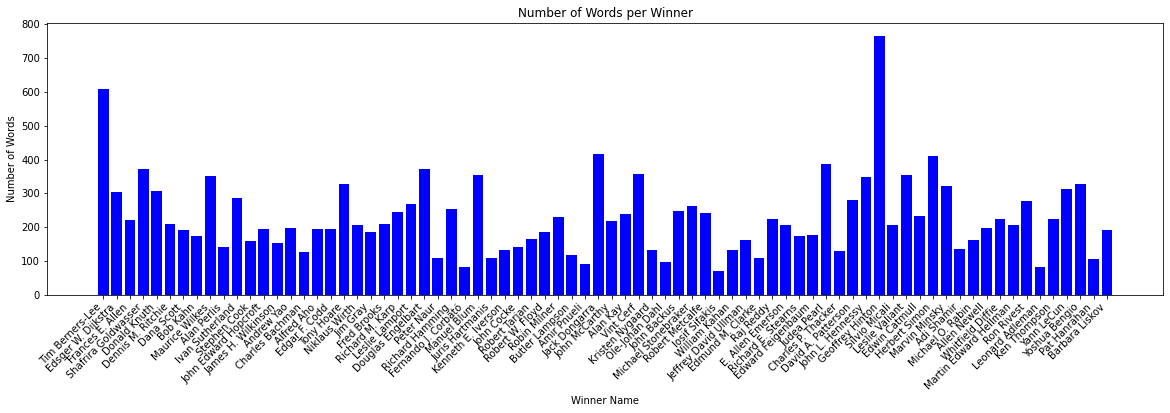

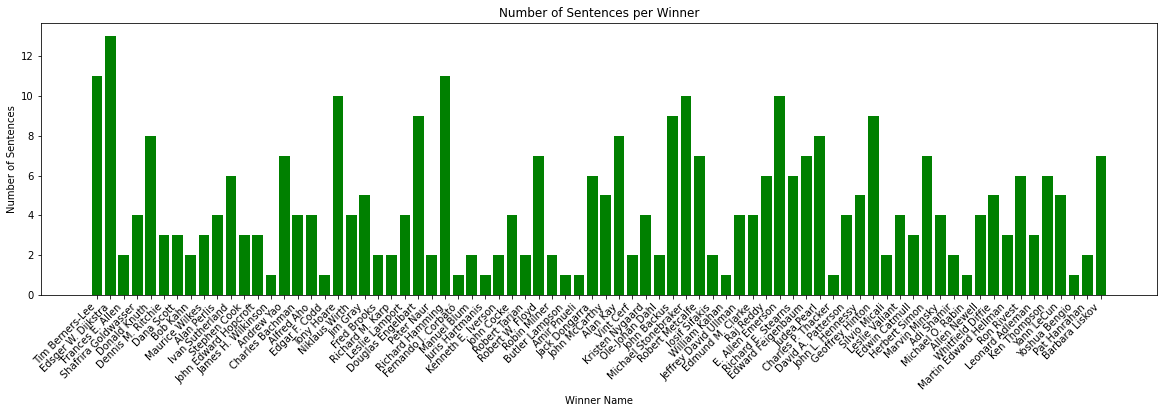

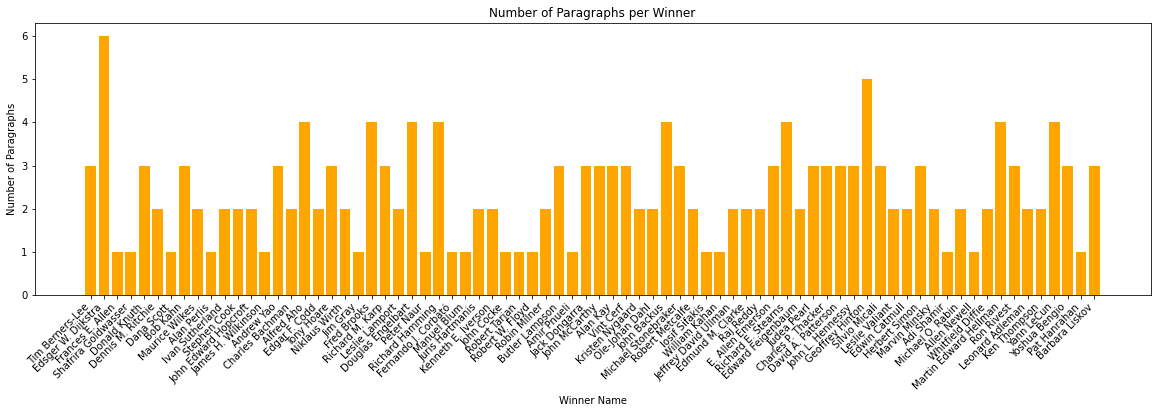

In [68]:
#Plotting the number of words for each winner
plt.figure(figsize=(20, 5))
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_words'], color='blue')
plt.xlabel('Winner Name')
plt.ylabel('Number of Words')
plt.title('Number of Words per Winner')
plt.xticks(rotation=45, ha='right')
plt.show()

#Plotting the number of sentences for each winner
plt.figure(figsize=(20, 5))
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_sentences'], color='green')
plt.xlabel('Winner Name')
plt.ylabel('Number of Sentences')
plt.title('Number of Sentences per Winner')
plt.xticks(rotation=45, ha='right')
plt.show()

#Plotting the number of paragraphs for each winner
plt.figure(figsize=(20, 5))
plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_paragraphs'], color='orange')
plt.xlabel('Winner Name')
plt.ylabel('Number of Paragraphs')
plt.title('Number of Paragraphs per Winner')
plt.xticks(rotation=45, ha='right')
plt.show()

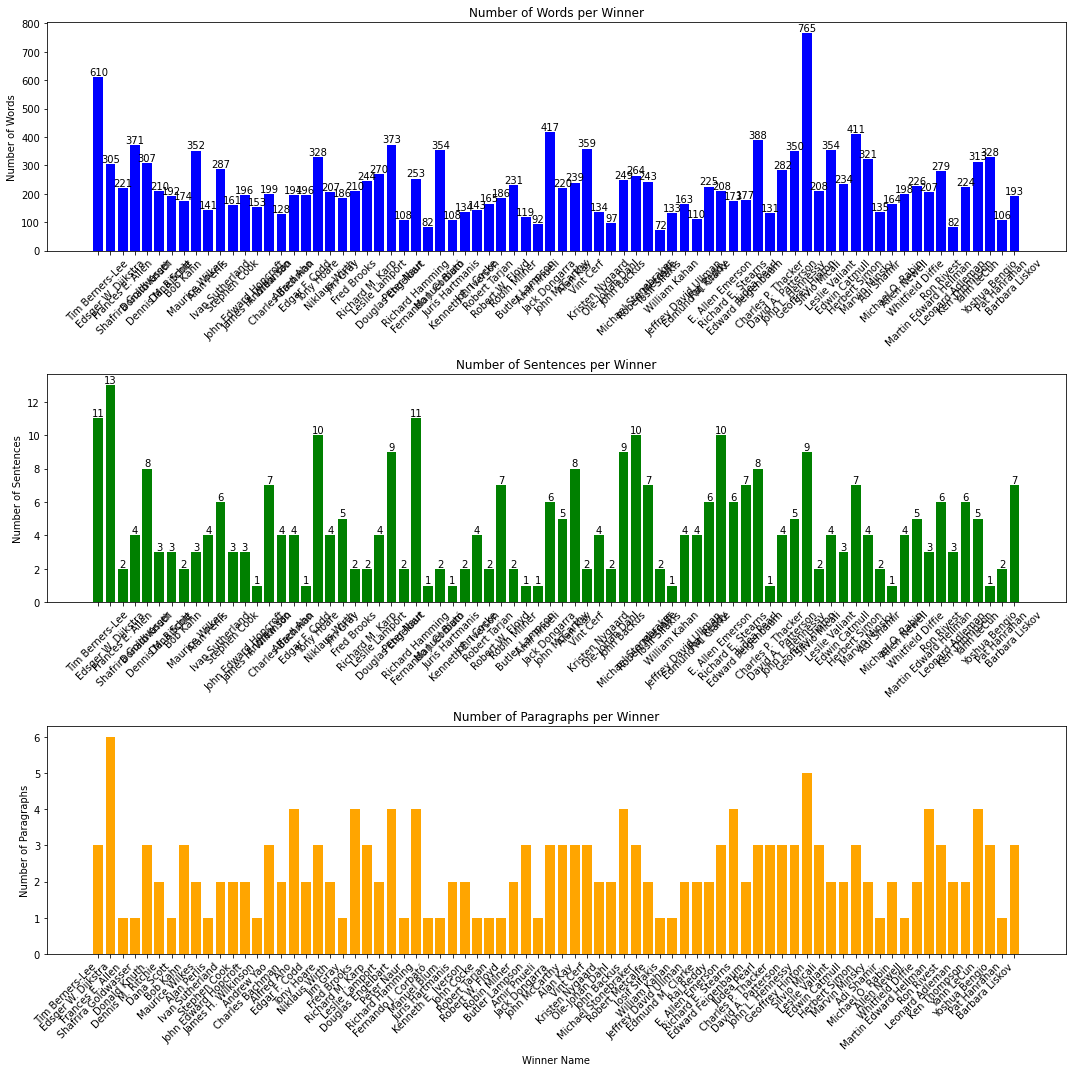

In [69]:
#Create subplots for all three barplots
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

#Plotting the number of words for each winner
axes[0].bar(award_winners_intro['winner_name'], award_winners_intro['count_words'], color='blue')
axes[0].set_ylabel('Number of Words')
axes[0].set_title('Number of Words per Winner')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
for i, v in enumerate(award_winners_intro['count_words']):
    axes[0].text(i, v, str(v), ha='center', va='bottom')


#Plotting the number of sentences for each winner
axes[1].bar(award_winners_intro['winner_name'], award_winners_intro['count_sentences'], color='green')
axes[1].set_ylabel('Number of Sentences')
axes[1].set_title('Number of Sentences per Winner')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
for i, v in enumerate(award_winners_intro['count_sentences']):
    axes[1].text(i, v, str(v), ha='center', va='bottom')

#Plotting the number of paragraphs for each winner
axes[2].bar(award_winners_intro['winner_name'], award_winners_intro['count_paragraphs'], color='orange')
axes[2].set_xlabel('Winner Name')
axes[2].set_ylabel('Number of Paragraphs')
axes[2].set_title('Number of Paragraphs per Winner')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

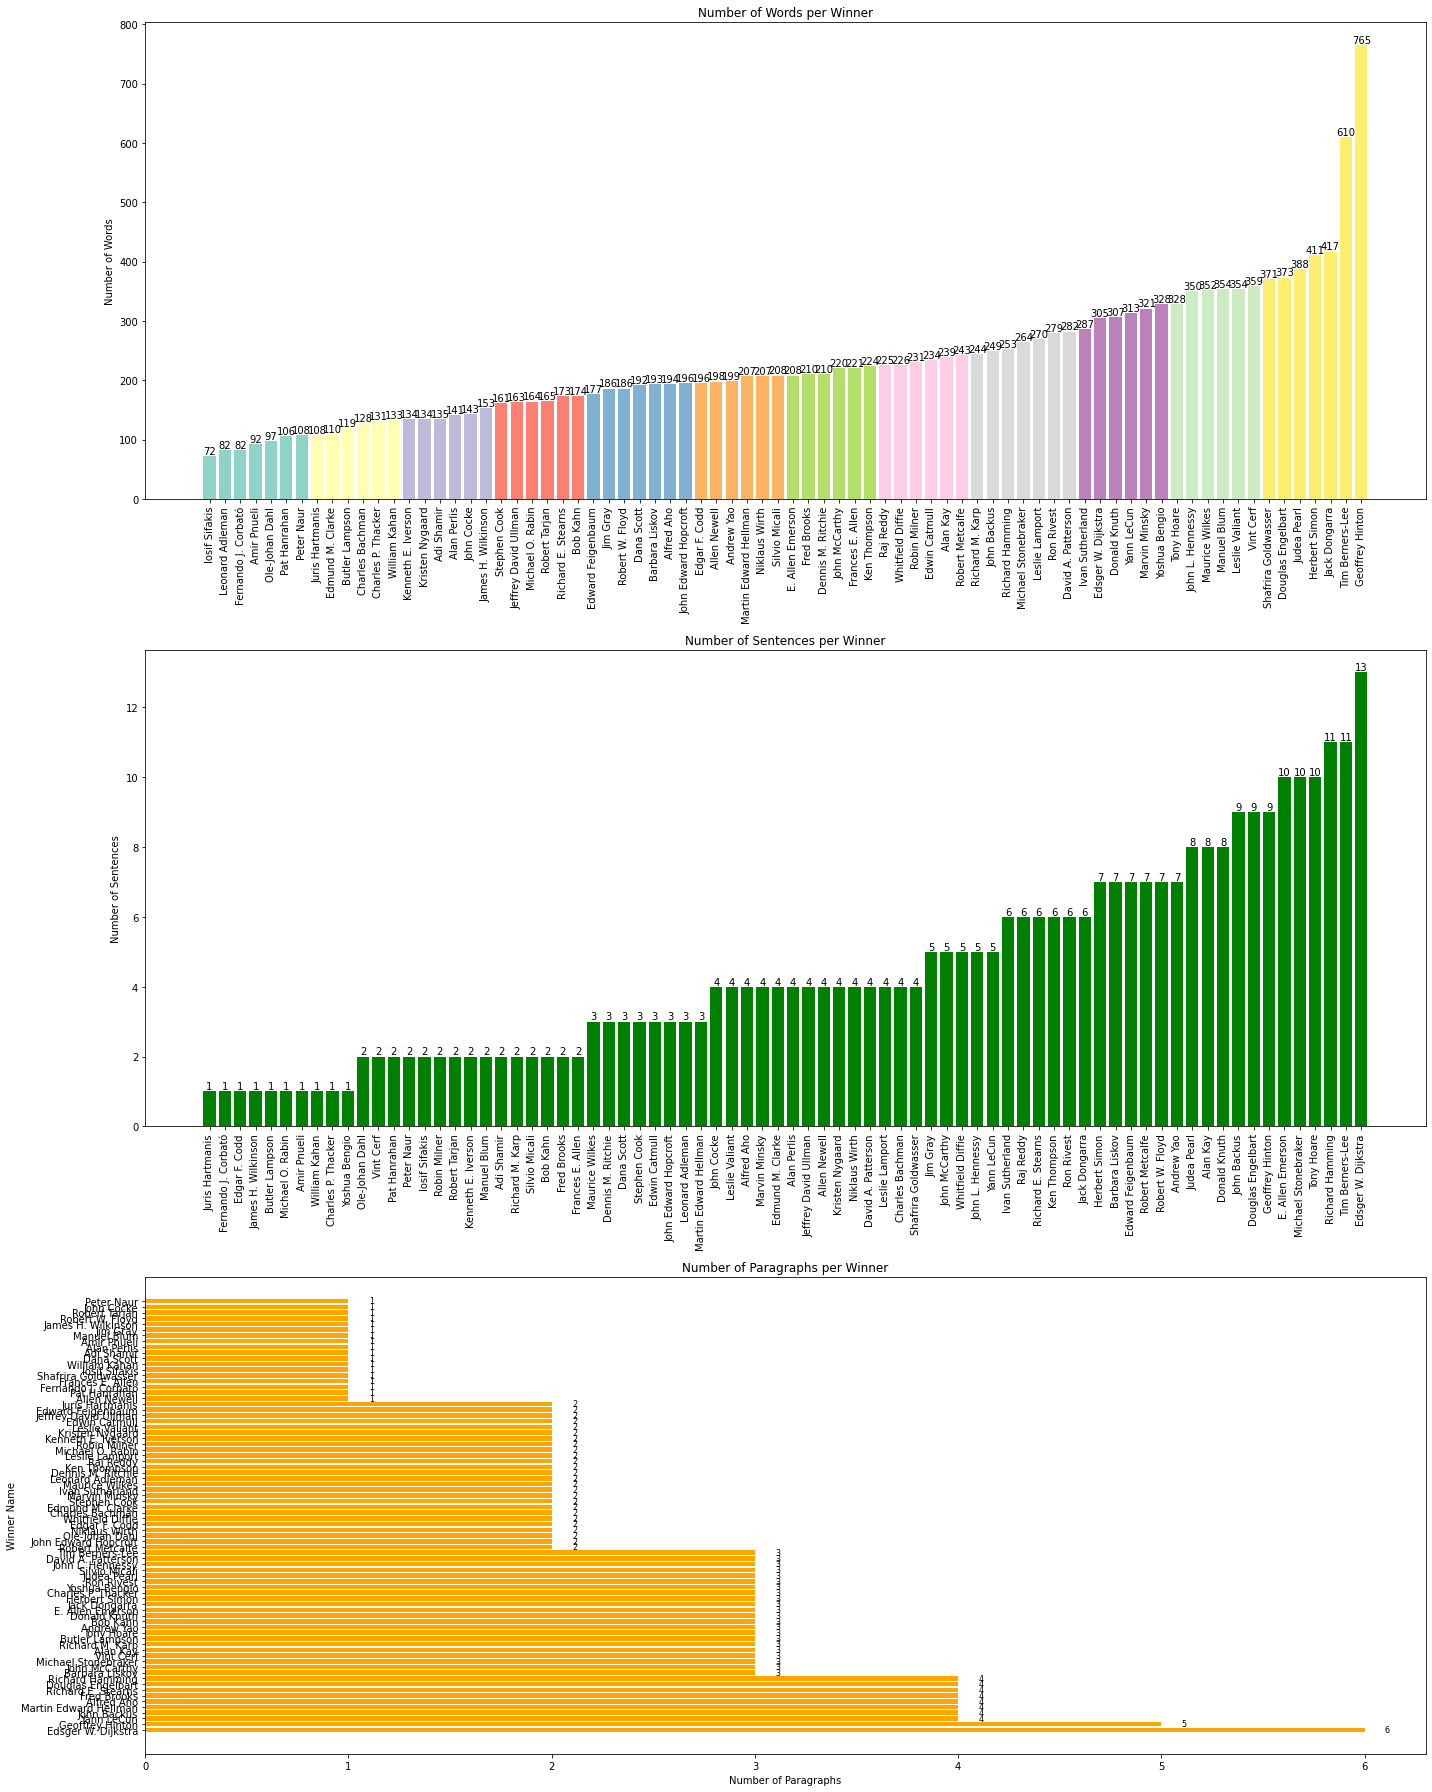

In [70]:
#Create subplots for all three barplots
fig, axes = plt.subplots(3, 1, figsize=(20, 25))

#Sort the DataFrame by count_words for the first plot
award_winners_intro_words_sorted = award_winners_intro.sort_values('count_words')

#Plotting the number of words for each winner
colors = plt.cm.Set3(np.linspace(0, 1, len(award_winners_intro_words_sorted)))
axes[0].bar(award_winners_intro_words_sorted['winner_name'], award_winners_intro_words_sorted['count_words'], color=colors)
axes[0].set_ylabel('Number of Words')
axes[0].set_title('Number of Words per Winner')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels
for i, v in enumerate(award_winners_intro_words_sorted['count_words']):
    axes[0].text(i, v, str(v), ha='center', va='bottom')


#Sort the DataFrame by count_sentences for the second plot
award_winners_intro_sentences_sorted = award_winners_intro.sort_values('count_sentences')

#Plotting the number of sentences for each winner
axes[1].bar(award_winners_intro_sentences_sorted['winner_name'], award_winners_intro_sentences_sorted['count_sentences'], color='green')
axes[1].set_ylabel('Number of Sentences')
axes[1].set_title('Number of Sentences per Winner')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels
for i, v in enumerate(award_winners_intro_sentences_sorted['count_sentences']):
    axes[1].text(i, v, str(v), ha='center', va='bottom')


#Sort the DataFrame by count_paragraphs for the third plot
award_winners_intro_paragraphs_sorted = award_winners_intro.sort_values('count_paragraphs')

#Plotting horizontal barplot for the number of paragraphs for each winner
axes[2].barh(award_winners_intro_paragraphs_sorted['winner_name'], award_winners_intro_paragraphs_sorted['count_paragraphs'], color='orange')
axes[2].set_xlabel('Number of Paragraphs')
axes[2].set_ylabel('Winner Name')
axes[2].set_title('Number of Paragraphs per Winner')
axes[2].invert_yaxis()  # Invert y-axis for ascending order
for i, v in enumerate(award_winners_intro_paragraphs_sorted['count_paragraphs']):
    axes[2].text(v + 0.1, i, str(v), ha='left', va='center', fontsize=8)  # Adjust text position for better spacing

plt.tight_layout()
plt.show()

In [71]:
#Extract the 15 most frequent bigrams from winners_bigrams
top_bigrams = sorted(winners_bigrams.items(), key=lambda x: x[1], reverse=True)[:15]

#Extract only unique bigrams (text) from the sorted winners_bigrams dictionary: top_bigrams
unique_bigrams = [bigram for bigram, frequency in top_bigrams]

#Calculate the frequency of each bigram in the intro text of award_winners
intro_texts = [info['intro'] for winner_name, info in award_winners.items()]
intro_bigram_frequencies = {bigram: [] for bigram in unique_bigrams}

for intro_text in intro_texts:
    intro_bigrams = list(bigrams(intro_text.split()))
    intro_bigram_counter = Counter(intro_bigrams)
    
    for bigram in unique_bigrams:
        intro_bigram_frequencies[bigram].append(intro_bigram_counter[bigram])

#Create a DataFrame from intro_bigram_frequencies
df = pd.DataFrame(intro_bigram_frequencies)

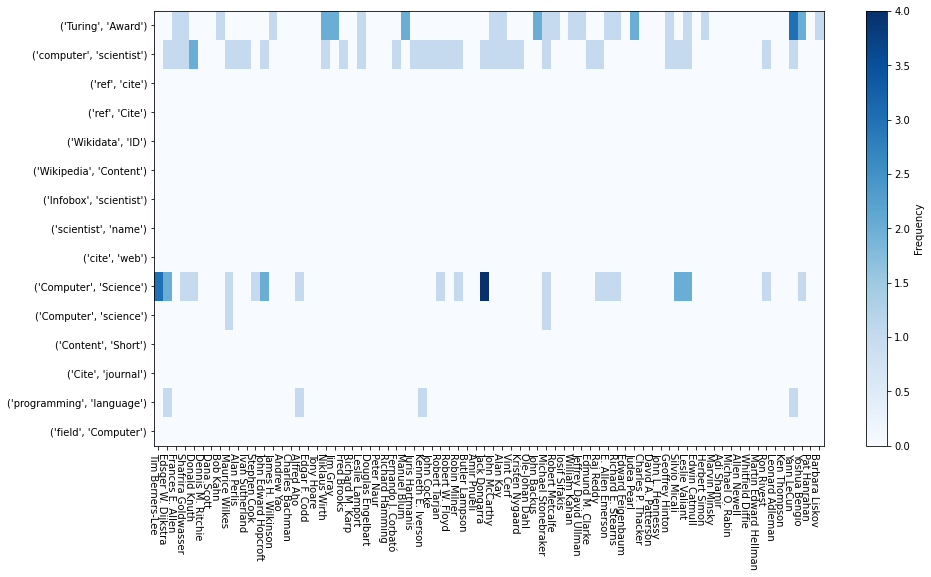

In [72]:
#Create the heatmap using matplotlib with a sequential colormap
fig, ax = plt.subplots(figsize=(15, 8))
heatmap = ax.imshow(df.T, cmap='Blues', aspect='auto', interpolation='nearest')

#Set axis labels
ax.set_xticks(np.arange(len(intro_texts)))
ax.set_yticks(np.arange(len(unique_bigrams)))
ax.set_xticklabels(list(award_winners.keys()), rotation=-90, ha='right')
ax.set_yticklabels(unique_bigrams)

#Print heatmap
cbar = plt.colorbar(heatmap)
cbar.set_label('Frequency')

plt.show()